# YOLOv3 network implementation

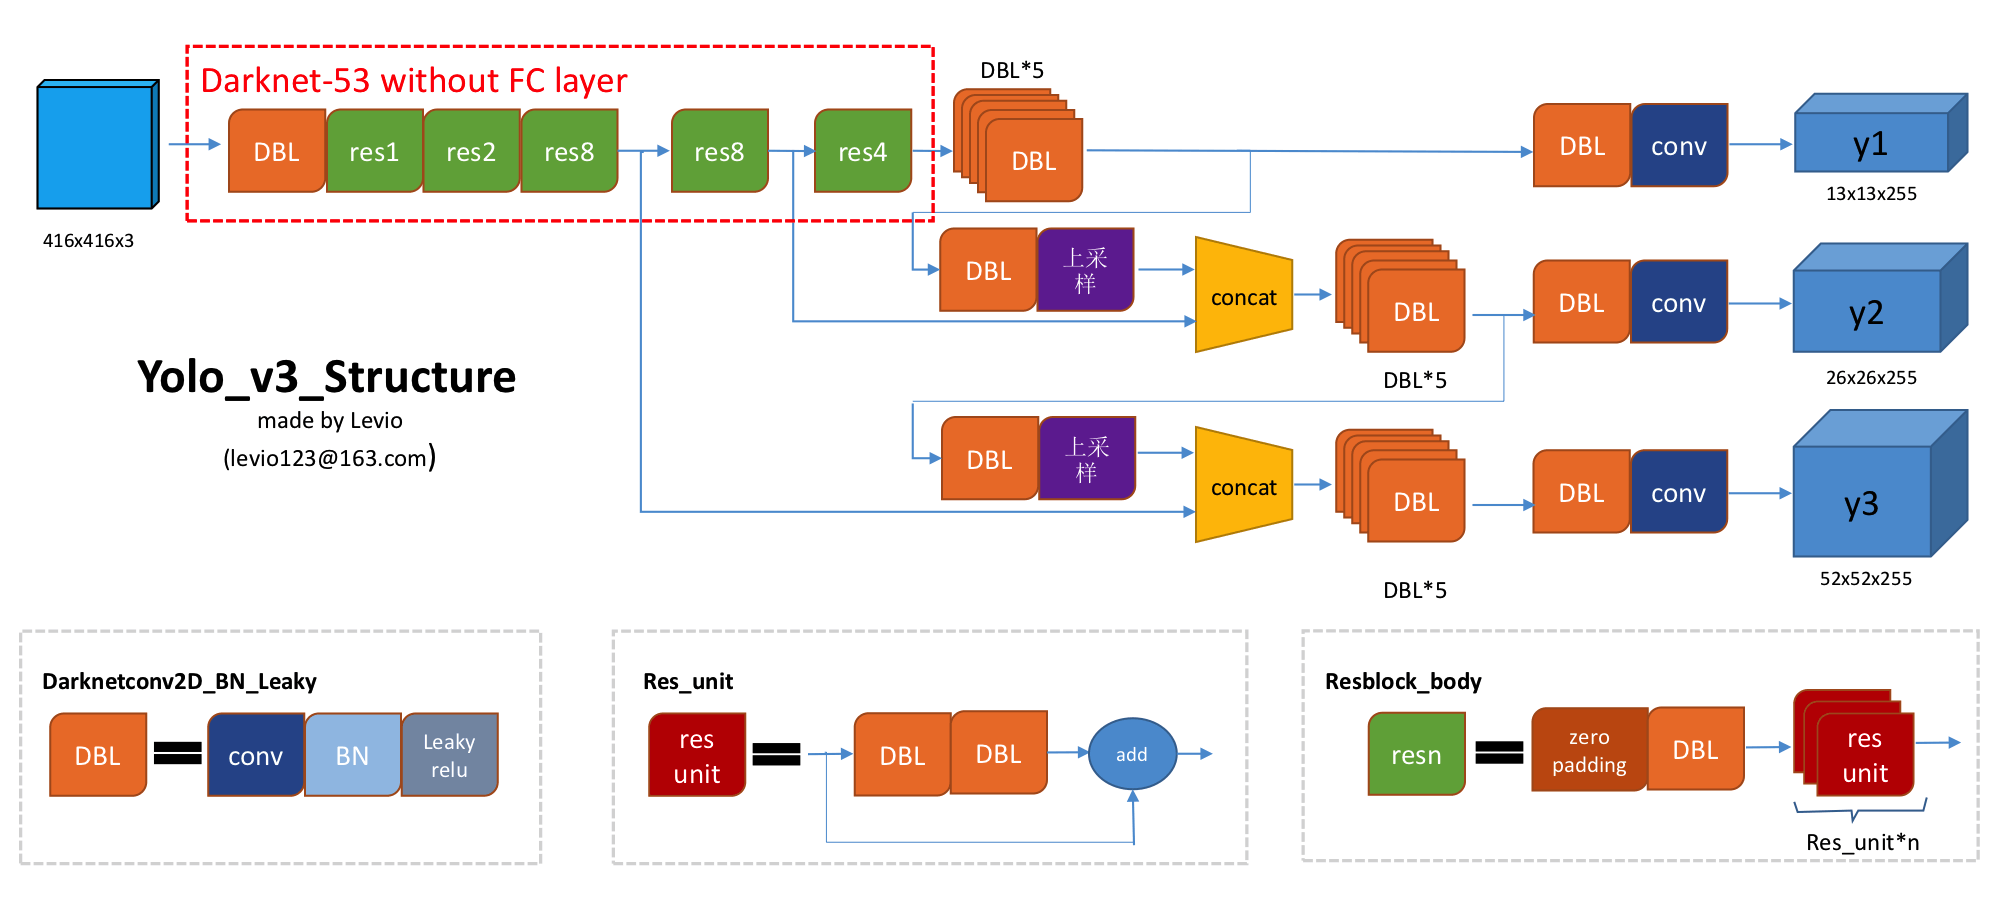

## Importing Main Libraries and Darknet Functions
You can find more info about that in the Darknet53_v1 Notebook, here i'm just gonna use them.
The Darknet Model now doesn't have a "classification" parameter no more and it outputs different tensor in order to be able to use them in different *lines*

In [1]:
# Utility libraries
from pathlib import Path

# Core libraries
import numpy as np
import tensorflow as tf

from tensorflow import Tensor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, Concatenate

# Useful Darknet Functions written in Darknet53 Notebook
import darknet53
from darknet53 import Conv2D_plus, ResidualUnit, ResidualBlock

In [2]:
def Darknet53_yolo(pretrained = False, name = None) -> Model:
    Z = inputs = Input(shape=(None, None, 3))
    Z = Conv2D_plus(Z, 32, 3)
    Z = ResidualBlock(Z, 64, 1)
    Z = ResidualBlock(Z, 128, 2)
    Z_3 = ResidualBlock(Z, 256, 8)
    Z_2 = ResidualBlock(Z_3, 512, 8)
    Z_1 = ResidualBlock(Z_2, 1024, 4)
    darknet = Model(inputs=inputs, outputs=(Z_1,Z_2,Z_3), name=name)
    if pretrained:
        darknet = darknet53.load_weights(darknet)
    return darknet

model = Darknet53_yolo(pretrained = True)

## Defining Anchors obtained via K-means
As we found in the K-mean analysis in the data preprocessing, here there are the bounding boxes:

In [3]:
yolo_anchors = np.array([(10, 10), (22, 23), (47, 33), (39, 81), (82, 54), (127, 86),
                         (118, 168), (194, 130), (257, 221)], np.float32)

## Defining YOLO Model
Here we get the actual YOLO model ready to be *fine trained*

In [3]:
def YoloConv2D(inputs, filters):
    A = Conv2D_plus(inputs, filters, 1)
    A = Conv2D_plus(A, filters*2, 3)
    A = Conv2D_plus(A, filters, 1)
    A = Conv2D_plus(A, filters*2, 3)
    A = Conv2D_plus(A, filters, 1)
    return A

def YoloOut(inputs, filters, anchors, classes):
    B = Conv2D_plus(inputs, filters * 2, 3)
    B = Conv2D(filters = anchors * (classes + 5),
               kernel_size = 1,
               strides = 1,
               padding = "same",
               use_bias = True)(B)
    B = tf.reshape(B, (-1,inputs.shape[1],inputs.shape[2],3,15))
    return B

def YoloUpsampling(inputs, filters):
    C = Conv2D_plus(inputs, filters, 1)
    C = UpSampling2D(2)(C)
    return C

In [ ]:
def YOLOv3(size=None, channels=3, classes=10, training=False):
    X = inputs = Input([size, size, channels])
    Z_1, Z_2, Z_3 = Darknet53_yolo(pretrained = True, name='darknet')(X)
    
    # Output number 1
    Z_1 = YoloConv2D(Z_1, 512)
    Z_out1 = YoloOut(Z_1, 512, 3, classes)
    
    # Output number 2
    Z_1 = YoloUpsampling(Z_1, 256)
    Z_2 = Concatenate()([Z_1, Z_2])
    Z_2 = YoloConv2D(Z_2, 256)
    Z_out2 = YoloOut(Z_2, 256, 3, classes)
    
    # Output number 3
    Z_2 = YoloUpsampling(Z_2, 128)
    Z_3 = Concatenate()([Z_2, Z_3])
    Z_3 = YoloConv2D(Z_3, 128)
    Z_out3 = YoloOut(Z_3, 128, 3, classes)
    
    if training:
        return Model(inputs, (Z_out3, Z_out2, Z_out1), name='YOLOv3')
    
yolo = YOLOv3(size = 1280,training = True)
yolo.summary()

# Note that with 80 classes the numbers of parameters is the same as yolov3.weights by Joe Redmon
#so we're sure we're doing the right thing